# 数据分析师市场需求研究

本文是关于数据分析师市场需求的小研究。


在这篇分析里，我主要想解决两个问题：
1. 哪一类人市场需求最高
2. 什么因素能影响工资水平


这里就以深圳市的数据分析岗为例，分析一下数据分析师的市场需求状况。

In [1]:
### 拉勾数据分析招聘岗位分析 ###

# 本文针对拉勾网上深圳数据分析岗位的招聘信息做分析。
# Programmer: Dan Qin
# Date: 2019.08.30

# import libraries
# 基础包
import pandas as pd
import matplotlib.pyplot as plt

# 文件处理包
import json
import xmltodict
import os
import fnmatch

# 分词统计与词云包
import jieba
import jieba.analyse
from wordcloud import WordCloud

import re

# 对pandas和matplotlib的显示设置
pd.set_option('display.max_columns', 20)
plt.rcParams.update({"font.family":"SimHei"})
plt.style.use("tableau-colorblind10")
%matplotlib inline

## 1. 数据提取

万年不变的第一步，做分析前得先有数据。
本分析所用数据是借助爬虫工具从拉勾网爬取的，详细的爬取教程请参照下面的链接。

In [8]:
# 利用集搜客爬取拉勾网上深圳数据分析岗招聘信息，需采用层级爬取
# 基础爬取教程参见：https://zhuanlan.zhihu.com/p/38884768 ; 层级爬取教程：https://www.gooseeker.com/doc/article-75-1.html
# 爬取源数据为xml格式

# 将xml文件转为json方便处理
def xml_to_json(input):
    '''
    Convert Xml to Json file.
    :param input: input file path, xml
    :return: NaN, write json into file
    '''
    # load xml
    if not os.path.exists(input.replace(".xml", ".json")):
        with open(input, 'r', encoding = "UTF-8", errors = "ignore") as f:
            xmlString = f.read()

        # convert xml to json
        output = input.replace(".xml", ".json")
        jsonString = json.dumps(xmltodict.parse(xmlString), ensure_ascii=False)
        with open(output, 'w', encoding="utf-8") as f:
            f.write(jsonString)

In [15]:
# 将爬取数据整合成dataframe

# 获取文件夹中的所有文件
path = "data/拉勾/"
filenames = []
for file in os.listdir(path):
    if fnmatch.fnmatch(file, "*.xml"):
        filenames.append(file)

# 用来放数据的df
df = pd.DataFrame(columns = ["公司名","行业","融资","公司网址","薪资","职位",
                             "经验","学历","员工规模","关键词","发布时间","职位诱惑",
                            "职位描述","地点"])


# 遍历文件名
for file in filenames:
    file = path + file
    # 将xml转为json
    xml_to_json(file)
    
    # 将json转为df
    output = file.replace(".xml", ".json")
    with open(output,encoding="utf-8") as json_data:
        d = json.load(json_data)
    
    data = pd.io.json.json_normalize(d["extraction"]["数据分析详情"]["item"])
    
    # 合并df
    df = pd.concat([df, data], sort = "False")

In [16]:
df.head(1)

,公司名,公司网址,关键词,发布时间,员工规模,地点,学历,经验,职位,职位描述,职位诱惑,薪资,融资,行业
0,路行通,http://www.klicen.com,数据分析,2019-09-27 发布于拉勾网,500-2000人,深圳 -\n 南山区 -\n ...,本科及以上 /,经验3-5年 /,数据分析师（碰撞场景探索与...,岗位职责：\n1.负责车辆碰撞场景的深度探索及数据建模。\n2.负责车辆碰撞数据的新特征挖掘...,"人性化管理,稳定平台,温馨化午餐",14k-20k,不需要融资,"移动互联网,消费生活"


In [17]:
# check df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 0
Data columns (total 14 columns):
公司名     216 non-null object
公司网址    216 non-null object
关键词     215 non-null object
发布时间    216 non-null object
员工规模    216 non-null object
地点      216 non-null object
学历      216 non-null object
经验      216 non-null object
职位      216 non-null object
职位描述    216 non-null object
职位诱惑    216 non-null object
薪资      216 non-null object
融资      216 non-null object
行业      216 non-null object
dtypes: object(14)
memory usage: 25.3+ KB


从拉勾网上我们爬取了深圳市数据分析岗位的招聘信息，共216条，包括公司名称、员工规模、行业、学历要求、经验要求、薪资水平等属性。为了方便下一步分析，接下来需要对这些属性进行标准化处理。

## 2. 数据清洗

这里的数据清洗分几个步骤进行：
1. 清理重复行。对于重复发布的岗位信息，我们只需要保留一条记录。
2. 清除多余文字。将各属性值中多余的描述性文字和换行符去掉。
3. 拆分薪资。这里给出的薪资是一个范围，我们将它拆成薪资上限和薪资下限，方便分析。
4. 提取地区。从地点描述中提取出区划名。

In [18]:
# 清理重复行
df_clr = df.drop_duplicates({"公司名","职位","职位描述"}).copy()

# 清除多余字符
df_clr["员工规模"] = df_clr["员工规模"].str.replace("人","")
df_clr["经验"] = df_clr["经验"].str.replace(" /","")
df_clr["经验"] = df_clr["经验"].str.replace("经验","")
df_clr["学历"] = df_clr["学历"].str.replace("学历","")
df_clr["学历"] = df_clr["学历"].str[:2]
df_clr["职位描述"] = df_clr["职位描述"].str.replace(" ","")
df_clr["职位描述"] = df_clr["职位描述"].str.replace("\n","")

# 拆分薪资
df_clr["薪资"] = df_clr["薪资"].str.replace("k","000")
df_clr[["薪资下限","薪资上限"]] = df_clr.薪资.str.split("-", expand = True)

# 提取地区
df_clr["地点"] = df_clr["地点"].str.replace(" ","")
df_clr["地点"] = df_clr["地点"].str.replace("\n","")
df_clr["地点"] = df_clr["地点"].str.replace("查看地图","")
df_clr["区划"] = df_clr["地点"].str[3:5]

df_clr = df_clr.drop(columns = ["薪资","发布时间"])


df_clr.head(1)

,公司名,公司网址,关键词,员工规模,地点,学历,经验,职位,职位描述,职位诱惑,融资,行业,薪资下限,薪资上限,区划
0,路行通,http://www.klicen.com,数据分析,500-2000,深圳-南山区-大冲-深南大道9680号大冲商务中心A座,本科,3-5年,数据分析师（碰撞场景探索与...,岗位职责：1.负责车辆碰撞场景的深度探索及数据建模。2.负责车辆碰撞数据的新特征挖掘和衍生，...,"人性化管理,稳定平台,温馨化午餐",不需要融资,"移动互联网,消费生活",14000,20000,南山


In [19]:
df_clr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 0
Data columns (total 15 columns):
公司名     214 non-null object
公司网址    214 non-null object
关键词     213 non-null object
员工规模    214 non-null object
地点      214 non-null object
学历      214 non-null object
经验      214 non-null object
职位      214 non-null object
职位描述    214 non-null object
职位诱惑    214 non-null object
融资      214 non-null object
行业      214 non-null object
薪资下限    214 non-null object
薪资上限    214 non-null object
区划      214 non-null object
dtypes: object(15)
memory usage: 26.8+ KB


In [2]:
# 保存表 - 方便下次使用
# df_clr.to_excel("data/data_job.xlsx", index = False)

# 载入表
df_clr = pd.read_excel("data/data_job.xlsx")
df_clr.head(1)

,公司名,公司网址,关键词,员工规模,地点,学历,经验,职位,职位描述,职位诱惑,融资,行业,薪资下限,薪资上限,区划
0,路行通,http://www.klicen.com,数据分析,500-2000,深圳-南山区-大冲-深南大道9680号大冲商务中心A座,本科,3-5年,数据分析师（碰撞场景探索与...,岗位职责：1.负责车辆碰撞场景的深度探索及数据建模。2.负责车辆碰撞数据的新特征挖掘和衍生，...,"人性化管理,稳定平台,温馨化午餐",不需要融资,"移动互联网,消费生活",14000,20000,南山


经过清洗后保留下来的记录还有214条。我们把这张洗好的表存起来，下一次分析就可以直接读取，而不用把上面的步骤再跑一遍。

## 3. 数据分析

接下来进入我们的正题。前面说过，这篇研究主要想解决两个问题：
1. 哪一类人市场需求最高
2. 什么因素能影响工资水平

首先我们先看一下深圳各区在招岗位数和薪资水平的差别。

### 3.1 深圳各区比较

#### 3.1.1 各区在招岗位数

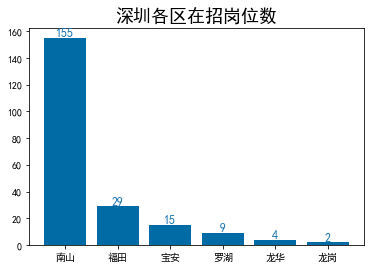

In [26]:
# 计算各区岗位数
count_region = df_clr.区划.value_counts().copy()

# 画图
plt.figure(1, figsize = (6,4))
plt.bar(count_region.index, count_region.values)
plt.title("深圳各区在招岗位数",fontsize = 18)
for i, v in enumerate(count_region.values):
    # 显示数字标签
    plt.text(i,v+1,v,color = "tab:blue",horizontalalignment='center', 
             fontsize = 12)  
plt.show()

可以看到，与预期一样，南山区不愧是深圳的科技中心，因为聚集了众多互联网企业，对数据分析师的需求远多于其它几个区。

不过这也可能因为数据来源是拉勾网，而拉勾网又以互联网公司为主，因此对结果产生了影响。

#### 3.1.2 各区平均工资

Text(0.5, 1.0, '深圳各区招聘薪资')

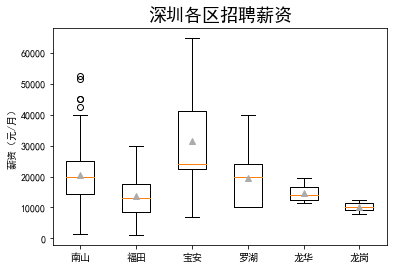

In [27]:
# 由于源数据中薪资为区间分布，这里取区间均值作为薪资值
df_clr["平均薪资"] = (df_clr["薪资下限"] + df_clr["薪资上限"])/2

# 按区划对平均薪资数据分组
avgpay_region = df_clr.groupby(["区划"])["平均薪资"]

avgpay_region_values = []
for group in count_region.index:
    m = avgpay_region.get_group(group).values
    avgpay_region_values.append(m)

# 绘制箱型图
plt.figure(figsize = (6,4))
ax = plt.subplot(111)
ax.boxplot(avgpay_region_values, showmeans = True)
ax.set_xticklabels(count_region.index)
ax.set_ylabel("薪资（元/月）")
ax.set_title("深圳各区招聘薪资",fontsize = 18)

在平均薪资这方面，南山区为2万左右/月，属于正常水平。招聘岗位仅次于南山区的福田区平均薪资为1.5万，在六个区中处于中下水平。而宝安给出的平均薪资是最高的，达到了3万多。可见为了在吸引人才方面与南山区竞争，宝安区给出了较高的薪水诱惑。

### 3.2 哪类人市场需求较高

下面我们从招聘工作中最常考虑的四个要素，来分析哪一类人的市场需求较高。这四个要素分别是工作经验、学历背景、职业技能和所属行业。

#### 3.2.1 工作经验

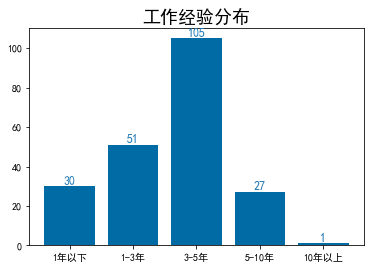

In [28]:
# “经验不限”和“应届毕业生”等同于1年以下，将其合并为一类
df_clr = df_clr.replace({"经验":{"不限":"1年以下","应届毕业生":"1年以下"}})

# 按经验年限对x轴标签排序
exp_val = df_clr["经验"].value_counts()
index = ["1年以下","1-3年","3-5年","5-10年","10年以上"]
values = [exp_val[x] for x in index]

# 绘制柱状图
plt.figure(figsize = (6,4))
plt.bar(index, values)
plt.title("工作经验分布",fontsize = 18)
for i, v in enumerate(values):
    plt.text(i,v+1,v,color = "tab:blue",horizontalalignment='center', 
             fontsize = 12)  # show values
plt.show()

可以看到，有3-5年工作经历的人市场需求是最高的，其次是拥有1-3年经验的人。

事实上，对数据分析师需求也是从近几年才渐渐兴起的，在行业还未成型的阶段，拥有一定经验的工作者确实会成为较为抢手的角色。而拥有三年以上工作经验，基本上已经可以独立完成项目，对于小公司和小团队来说会是优先考虑的类型。

#### 3.2.2 学历

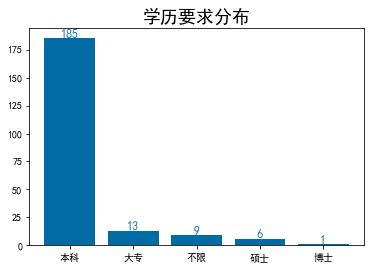

In [29]:
# 统计各学历背景的岗位数
edu_val = df_clr.学历.value_counts()

# 绘制柱状图
plt.figure(figsize = (6,4))
plt.bar(edu_val.index, edu_val.values)
plt.title("学历要求分布",fontsize = 18)
for i, v in enumerate(edu_val.values):
    plt.text(i,v+1,v,color = "tab:blue",horizontalalignment='center', 
             fontsize = 12)  # show values
plt.show()

超过85%的岗位都要求应聘者具备本科学历，这也与目前国内的行业形势相符。数据分析的工作对综合分析能力要求较高，因而对学历的要求也会相对高一些。

#### 3.2.3 职业技能

In [12]:
# 由于职位描述中包含大量中文，这里只提取软件类的英文技能
def extract_eng(text):
    eng = re.compile("[^a-z^A-Z]")
    str = eng.sub(" ",text)
    return str
    
df_clr["技能要求"] = df_clr["职位描述"].apply(extract_eng)
df_clr["技能要求"] = df_clr["技能要求"].str.split()
df_clr.head(1)

,公司名,公司网址,关键词,员工规模,地点,学历,经验,职位,职位描述,职位诱惑,融资,行业,薪资下限,薪资上限,区划,平均薪资,技能要求
0,路行通,http://www.klicen.com,数据分析,500-2000,深圳-南山区-大冲-深南大道9680号大冲商务中心A座,本科,3-5年,数据分析师（碰撞场景探索与...,岗位职责：1.负责车辆碰撞场景的深度探索及数据建模。2.负责车辆碰撞数据的新特征挖掘和衍生，...,"人性化管理,稳定平台,温馨化午餐",不需要融资,"移动互联网,消费生活",14000,20000,南山,17000.0,"[Python, MATLAB, R]"


(-0.5, 899.5, 599.5, -0.5)

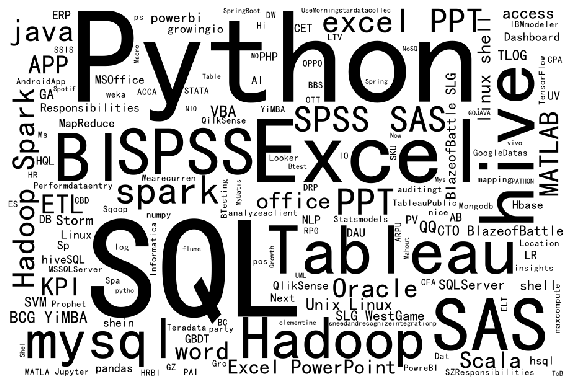

In [13]:
text = df_clr["技能要求"].dropna().to_string()

# 绘制词云图
plt.figure(figsize=(10,8))
wordcloud = WordCloud(font_path = "simhei.ttf",
                      background_color = "white",
                      min_font_size = 10,
                      color_func = lambda *args, **kwargs:(0,0,0),
                      width = 900, height = 600).generate(text)
plt.imshow(wordcloud)
plt.axis("off")

In [14]:
# 将技能规整到一个list中
temp_list = df_clr["技能要求"].tolist()
flat_list = [word for sublist in temp_list for word in sublist]
flat_list = [str.upper() for str in flat_list]

# 统计词频
word_freq = {word:flat_list.count(word) for word in flat_list}
word_freq = pd.DataFrame(list(word_freq.items()),columns = ["word","freq"])
word_freq = word_freq.sort_values(by = ["freq"],ascending = False)
word_freq.head(1)

,word,freq
3,SQL,126


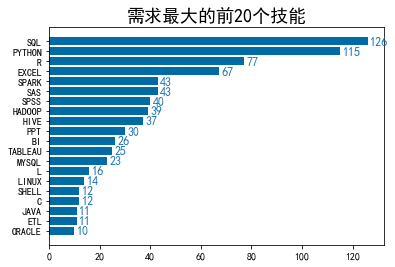

In [30]:
# 绘制前20个高频技能条形图
plt.figure(figsize=(6,4))
plt.barh(word_freq.word[:20],word_freq.freq[:20])
plt.title("需求最大的前20个技能",fontsize = 18)
for i, v in enumerate(word_freq.freq[:20]):
    plt.text(v+1,i,v,color = "tab:blue",verticalalignment='center', 
             fontsize = 12)  # show values
plt.gca().invert_yaxis()
plt.show()

接下来是对于职业技能的分析。这里我们只考虑数据分析的通用技能（即编程语言、数据库语言等），而不考虑管理、行业经验等指向性明确的技能。

排名前三的技能分别是SQL、Python和R。超过半数的岗位都明确要求需要掌握SQL语言。作为数据分析的基础，了解一定的数据库提取和清洗方法是必要的。Spark作为开源的大规模数据处理框架，它的应用也越来越广泛，其市场需求甚至排在Hadoop之上。Excel就不用说了，老牌数据处理软件，我个人觉得它处理图表比Python和R更好用，在易操作性上甚至优于专业的报表软件Tableau。

#### 3.2.4 行业

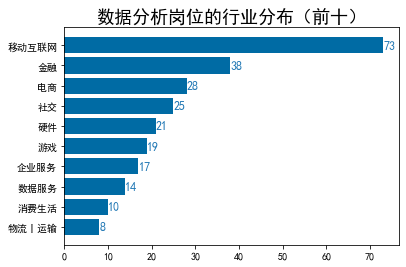

In [33]:
# 统计行业词频 
temp_list = df_clr["行业"].str.split(",")
flat_list = [word for sublist in temp_list for word in sublist]
word_freq_indstry = {word:flat_list.count(word) for word in flat_list}
word_freq_indstry = pd.DataFrame(list(word_freq_indstry.items()),columns = ["word","freq"])
word_freq_indstry = word_freq_indstry.sort_values(by = ["freq"],ascending = False)


# 绘图
plt.figure(figsize=(6,4))
plt.barh(word_freq_indstry.word[:10],word_freq_indstry.freq[:10])
plt.title("数据分析岗位的行业分布（前十）",fontsize = 18)
for i, v in enumerate(word_freq_indstry.freq[:10]):
    plt.text(v,i,v,color = "tab:blue",verticalalignment='center', 
             fontsize = 12)  # show values
plt.gca().invert_yaxis()
plt.show()

最后来看下哪些行业对数据分析师的需求较多。由上图可知，移动互联网、金融和电商是数据分析岗位分布最多的前三个行业，社交排名第四。这几个行业都有一个共同点，就是会产生大量的数据。

总结一下，回答我们在开头提出的第一个问题：哪类人的市场需求较高？

从分析得出的结论是，拥有3-5年经验、本科学历、掌握SQL语言且从事与移动互联网、金融或电商相关行业的人，在应聘工作时会比较有优势。

### 3.3 工资与什么挂钩

接下来看看我们最关心的一个问题：什么因素会影响工资水平？

影响工资的因素可分为内因和外因，其中内因包括个人自身的工作经验和学历，外因则包括所处行业和公司规模。

#### 3.3.1 工作经验

Text(0.5, 1.0, '经验与薪资关系')

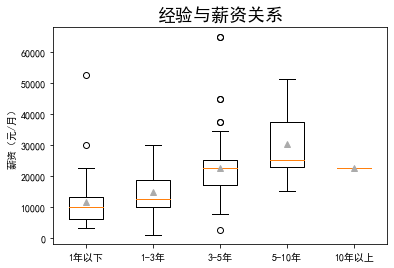

In [34]:
# 按经验对薪资进行分组
avgpay_exp = df_clr.groupby(["经验"])["平均薪资"]

# 统计各经验组的薪资数据，index为先前已排序的经验分组
avgpay_exp_values = []
for group in index:
    m = avgpay_exp.get_group(group).values
    avgpay_exp_values.append(m)

# 绘制箱型图
plt.figure(figsize = (6,4))
ax = plt.subplot(111)
ax.boxplot(avgpay_exp_values, showmeans = True)
ax.set_xticklabels(index)
ax.set_ylabel("薪资（元/月）")
ax.set_title("经验与薪资关系",fontsize = 18)

首先是看起来对工资影响最大的工作经验。可以看到随着经验年限提升，薪资也不断提升。

在深圳，新人数据分析师的起薪一般可达到1万左右，三年是一个门槛，从三年到五年薪资是线性上升的。拥有三年以上经验平均可达到2万左右的薪资水平，五年以上可达3万。十年以上的岗位样本量太少，不具备参考价值。

#### 3.3.2 学历

Text(0.5, 1.0, '学历与薪资关系')

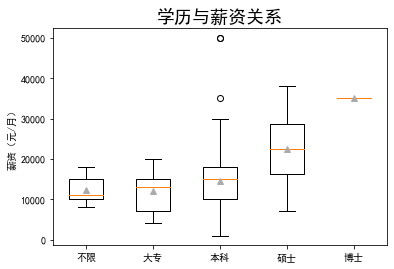

In [35]:
# 按学历对薪资进行分组
# 由于薪资是根据经验年限给的一个范围，这里仅看学历对薪资的影响，因而取薪资范围的最小值
pay_edu = df_clr.groupby(["学历"])["薪资下限"]

# 统计各学历组的薪资数据，edu_val为学历分组
edu_index = ["不限","大专","本科","硕士","博士"]
pay_edu_values = []
for group in edu_index:
    m = pay_edu.get_group(group).values
    pay_edu_values.append(m)

# 绘制箱型图
plt.figure(figsize = (6,4))
ax = plt.subplot(111)
ax.boxplot(pay_edu_values, showmeans = True)
ax.set_xticklabels(edu_index)
ax.set_ylabel("薪资（元/月）")
ax.set_title("学历与薪资关系",fontsize = 18)

接下来看看薪资与学历的关系。随着学历增长，薪资增长幅度比较明显。本科平均能达到1.2万左右的月薪，硕士是2万，博士是3.5万。可见教育经历对数据分析师薪资水平也有较大的影响。

#### 3.3.3 职业技能

第三个看的是职业技能对工资的影响。

这里我们只看需求最多的前十个技能。由前面分析可知排行前十的技能如下：

In [68]:
word_freq[:10]

,word,freq
3,SQL,126
0,PYTHON,115
2,R,77
5,EXCEL,67
14,SPARK,43
4,SAS,43
6,SPSS,40
7,HADOOP,39
18,HIVE,37
9,PPT,30


Text(0.5, 1.0, '职业技能与薪资关系')

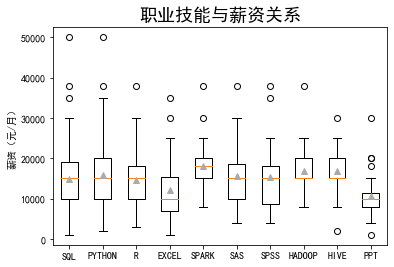

In [36]:
# 同理，这里只取薪资下限进行统计
skill_pay = []
for skill in word_freq.word[:10]:
    temp_df = df_clr.loc[df_clr["职位描述"].str.contains(skill, case = False)]
    skill_pay.append(temp_df["薪资下限"].tolist())
    
# 绘制箱型图
plt.figure(figsize = (6,4))
ax = plt.subplot(111)
ax.boxplot(skill_pay, showmeans = True)
ax.set_xticklabels(word_freq.word[:10])
ax.set_ylabel("薪资（元/月）")
ax.set_title("职业技能与薪资关系",fontsize = 18)

从上图可以看出，几种常见的编程语言对薪资的影响没有太大差异。不管你用的是Python、SQL，还是SAS、SPSS，只要可以很好地完成工作，对工资都没有绝对的影响。

其中除了excel和ppt作为基本的办公工具，相较其他技能对薪资的贡献稍显劣势，Spark作为新兴的数据处理框架，人才较少，招聘岗位给出的工资也比较高。

#### 3.3.4 行业

最后行业的分析与职业技能同理，这里只取需求最多的前十个行业来比较。

Text(0.5, 1.0, '行业与薪资关系')

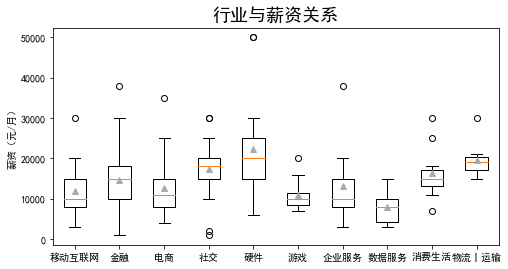

In [40]:
# 行业同理，只取前十进行分析，薪资只取下限
indstry_pay = []
for industry in word_freq_indstry.word[:10]:
    temp_df = df_clr.loc[df_clr["行业"].str.contains(industry, case = False)]
    indstry_pay.append(temp_df["薪资下限"].tolist())
    
# 绘制箱型图
plt.figure(figsize = (8,4))
ax = plt.subplot(111)
ax.boxplot(indstry_pay, showmeans = True)
ax.set_xticklabels(word_freq_indstry.word[:10])
ax.set_ylabel("薪资（元/月）")
ax.set_title("行业与薪资关系",fontsize = 18)

在行业的影响上，物流运输业和硬件制造相关行业平均薪资较高，月薪接近2万。紧随其后的是社交和生活消费相关的行业，平均月薪在1.5万左右。招聘岗位最多的移动互联网行业平均薪资反而较低，仅1万左右。

#### 3.3.5 公司规模

Text(0.5, 1.0, '员工规模与薪资关系')

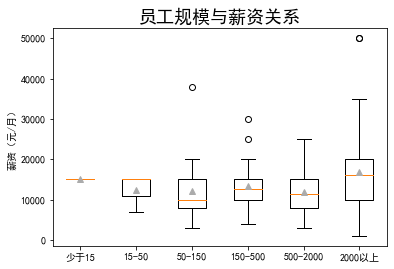

In [38]:
emply_index = ["少于15","15-50","50-150","150-500","500-2000","2000以上"]

# 按员工规模对薪资进行分组
pay_emply = df_clr.groupby(["员工规模"])["薪资下限"]

pay_emply_values = []
for group in emply_index:
    m = pay_emply.get_group(group).values
    pay_emply_values.append(m)

# 绘制箱型图
plt.figure(figsize = (6,4))
ax = plt.subplot(111)
ax.boxplot(pay_emply_values, showmeans = True)
ax.set_xticklabels(emply_index)
ax.set_ylabel("薪资（元/月）")
ax.set_title("员工规模与薪资关系",fontsize = 18)

最后看一下公司规模对他们给出的岗位的薪资影响。

虽然从平均薪资来看公司规模对薪资水平的影响不大，但从中位数看，超过2000人的大公司提供的薪资水平比较高，50%的岗位都给到了1.5万以上。相较而言，小公司多为新兴公司，需要招纳人才，起薪给的也比较高，多在1.5万左右。而中间规模的公司从整体看给的薪水是最少的，150人以下的公司多数月薪给不到1万。

总结一下，有哪些因素会对工资产生影响？

首先工作经验和学历与工资的关系是正相关的，学历越高、工作年限越长，工资水平就越高。不同的数据分析语言或者软件的使用对工资的没有太大影响。公司的规模一定程度上也决定了它能提供的薪资范围。最后，不同行业对数据分析师的需求是不一样的，物流运输业与硬件制造业的岗位薪资较高。

### 3.4 延伸分析

最后再来一点延伸分析。看看哪家公司招的岗位最多、哪家钱给得最多以及哪家福利最好。

#### 3.4.1 公司常见福利

(-0.5, 899.5, 599.5, -0.5)

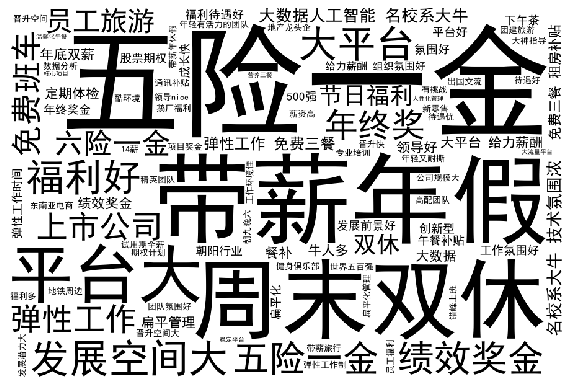

In [27]:
# 公司福利词云
text = df_clr["职位诱惑"].dropna().to_string()

# 绘制词云图
plt.figure(figsize=(10,8))
wordcloud = WordCloud(font_path = "simhei.ttf",
                      background_color = "white",
                      min_font_size = 10,
                      color_func = lambda *args, **kwargs:(0,0,0),
                      width = 900, height = 600).generate(text)
plt.imshow(wordcloud)
plt.axis("off")

五险一金、带薪年假、周末双休这些本应是理所当然的工作条件，居然也可以作为公司福利在招聘时做宣传。

在这些福利之中，免费三餐、租房补贴是我觉得最有用的。温饱问题解决了，才能心无旁骛地工作。

#### 3.4.2 该怎么选公司

##### 招聘岗位最多的公司

In [29]:
df_clr["公司名"].value_counts()[:10]

腾讯              20
OPPO            12
顺丰科技有限公司         8
字节跳动             7
阿卡索外教网           6
微众银行             6
一面数据             6
京东集团             5
乐逗游戏             4
深圳白骑士大数据有限公司     4
Name: 公司名, dtype: int64

可以看到，招聘岗位最多的公司是腾讯，其次是OPPO，排第三的是顺丰。

##### 给钱最多的公司 

In [43]:
row_indexup = df_clr["薪资上限"].idxmax()
row_indexdn = df_clr["薪资下限"].idxmax()

print("给钱最多的公司：",df_clr["公司名"].iloc[row_indexup],"(",df_clr["薪资上限"].iloc[row_indexup],"万)")
print("起薪最高的公司：",df_clr["公司名"].iloc[row_indexdn],"(",df_clr["薪资下限"].iloc[row_indexdn],"万)")

给钱最多的公司： vivo ( 80000 万)
起薪最高的公司： vivo ( 50000 万)


不论条件看单一岗位，给钱最多和起薪最高的公司都是vivo。

下面是在同等学历和工作经验条件下，起薪最高的公司：

In [33]:
# 同等学历和工作经验条件下，起薪最多的公司
df_clr.groupby(["学历","经验"]).max(level = "薪资下限")

公司名                          公司网址  区划      员工规模  \
学历 经验                                                                
不限 1-3年         银雁金融服务  https://www.lagou.com/gon...  福田  500-2000   
   3-5年         超级猩猩健身  https://www.lagou.com/gon...  福田    50-150   
   5-10年        阿卡索外教网     http://www.acadsoc.com.cn  罗湖    2000以上   
   不限               传易          http://transsnet.com  南山   150-500   
博士 5-10年          京东集团            https://www.jd.com  宝安    2000以上   
大专 1-3年         阿卡索外教网      http://www.waladigi.com/  罗湖    50-150   
   1年以下           乐格信息  https://www.localgravity.com  福田   150-500   
   3-5年             华策      http://www.smart-dec.com  福田    50-150   
   5-10年          爱问科技  https://www.lagou.com/gon...  龙华  500-2000   
   不限              飞诺达  http://www.lagou.com/gong...  宝安   150-500   
   应届毕业生        阿卡索外教网  https://www.lagou.com/gon...  罗湖    2000以上   
本科 1-3年         阿卡索外教网     https://www.yimian.com.cn  龙岗  500-2000   
   10年以上         平安智慧城        http://city.pingan.com  南山    2000以上   
   1年以下           舟恩信息    http://www.leyinetwork.com  福田   150-500   
   3-5年           鹏开信息             www.szeastroc.com  龙华      少于15   
   5-10年      顺丰科技有限公司  https://www.lagou.com/gon...  罗湖  500-2000   
   不限             长亮科技     https://www.yimian.com.cn  福田  500-2000   
   应届毕业生        阿卡索外教网     https://www.yimian.com.cn  罗湖  500-2000   
硕士 3-5年             腾讯  https://www.wesure.cn/ind...  南山    2000以上   
   5-10年  深圳白骑士大数据有限公司      https://www.baiqishi.com  南山    50-150   
   应届毕业生        深圳中原地产       http://hz.centanet.com/  南山    2000以上   

                                        地点                   职位  \
学历 经验                                                             
不限 1-3年          深圳-福田区-福田保税区市花路1号联合金融大厦B座        数据分析师(J12931)   
   3-5年              深圳-福田区-福田区嘉里建设广场2座10楼              游戏数据分析师   
   5-10年         深圳-罗湖区-国贸-嘉宾路2018号处深华大厦7楼            业务建模数据分析师   
   不限                 深圳-南山区-科技生态园2栋C座7-8楼       数据分析专员(J10236)   
博士 5-10年          深圳-宝安区-新安-海秀路21号龙光世纪大厦B座        广告数据分析师leader   
大专 1-3年   深圳-罗湖区-深圳市罗湖区桃园路254号HALO广场四期5-9层           数据分析（渠道方向）   
   1年以下               深圳-福田区-下沙-海松大厦B座3a01              初级数据分析师   
   3-5年      深圳-福田区-岗厦-金田路3038号现代国际商务大厦32层                数据分析师   
   5-10年                深圳-龙华新区-宝能科技园8栋16层         高级数据分析师（ AW)   
   不限                深圳-宝安区-新安-翻身地铁站金宝商务大厦                 数据分析   
   应届毕业生     深圳-罗湖区-国贸-嘉宾路2018号处深华商业大厦7楼整层                数据分析师   
本科 1-3年           深圳-龙岗区-坂田-坂雪岗大道神舟承运大厦四楼东        部门数据分析师（管理运营）   
   10年以上                     深圳-南山区-前海自贸大厦  4721FP-智慧法律-资深数据...   
   1年以下                  深圳-福田区-新洲-购物公园地铁站                 数据分析   
   3-5年                     深圳-龙华新区-港深国际中心            高级游戏数据分析师   
   5-10年                       深圳-罗湖区-华润大厦   高级顾问 / 经理 （财务数据...   
   不限                  深圳-福田区-车公庙-东海国际中心A座             银行数据分析岗位   
   应届毕业生     深圳-罗湖区-国贸-嘉宾路2018号处深华商业大厦7楼整层         管理运营部门-数据分析师   
硕士 3-5年                深圳-南山区-科技园-高新园飞亚达大厦     风控（海外）策略及数据分析...   
   5-10年        深圳-南山区-科技园-科苑路讯美科技广场3号楼609            高级医疗数据分析师   
   应届毕业生          深圳-南山区-后海-创业路1777号海信南方大厦               数据分析专员   

                                                       职位描述  \
学历 经验                                                         
不限 1-3年   工作职责:1、负责公司业务数据分析和挖掘工作；2、跟进业务各数据指标的计算和分析，运营数据分...   
   3-5年   岗位职责：1、负责规划、跟进、梳理微信游戏产品数据上报和测试；2、负责对微信游戏运营数据进行...   
   5-10年  岗位职责：1.通过数据分析、监控和日常数据挖掘（语音和文本数据），提供相应的运营建议，并推动...   
   不限     工作职责:1、负责运营数据整理规划工作，监控日常关键数据并分析异常变化，提交数据分析报告；2...   
博士 5-10年  工作内容:1、需求把控：较强的需求把控能力，能够准确的理解上级及同级的各类数据及分析需求，并...   
大专 1-3年   工作职责负责Now直播数据体系建设，包括搭建数据仓库，建立指标体系，完成数据分析，报表开发及...   
   1年以下   【岗位职责】：    1、负责零售数据信息的搜集、整理、录入、编辑、更新与维护等工作；   ...   
   3-5年   为项目外派驻岗，到深圳市罗湖区深业中心大厦上班（平安项目），介意慎投岗位职责：1、负责理解机...   
   5-10年  工作职责： 1、负责游戏数据分析体系搭建，包括TLOG埋点、日志上报、分析系统的规划等；2、...   
   不限     任职资格：1、逻辑分析能力强，对数据敏感，良好的学习能力和抗压能力；2、可熟练使用Excel...   
   应届毕业生  工作职责：1，根据公司发展战略规划和部门工作情况，对价格进行管理与监控，保证平台商品价格优势...   
本科 1-3年   负责对接用户需求，管理用户期望，将需求进行有效拆解；将商业语言转化成数据语

##### 福利最好的公司

在深圳，住房才是最重要的！所以我们就来看看提供住房补贴福利的公司有哪些。

In [44]:
df_clr[df_clr["职位诱惑"].str.contains(".房.",regex = True)]

,公司名,公司网址,关键词,员工规模,地点,学历,经验,职位,职位描述,职位诱惑,融资,行业,薪资下限,薪资上限,区划
26,字节跳动,http://www.bytedance.com,营销\n 数字...,2000以上,深圳-南山区-南海大道2163号来福士广场15层,本科,3-5年,数据分析师-游戏方向,职位职责：1、搭建游戏业务数据体系，通过数据分析挖掘用户需求，优化产品功能，推动业务目标达成...,弹性工作，免费三餐，餐补，租房补贴,C轮,文娱丨内容,20000,40000,南山
94,字节跳动,http://www.bytedance.com,产品经理,2000以上,深圳-南山区-创业路3023号公园一号办公楼,本科,3-5年,资深数据分析师-反作弊方向,职位职责：1、分析头条各产品线用户数据，发现用户异常问题，提高业务风控效果；2、有效利用公司...,六险一金，弹性工作，免费三餐，租房补贴,C轮,文娱丨内容,25000,50000,南山
95,字节跳动,http://www.bytedance.com,数据分析,2000以上,深圳-南山区-南海大道2163号来福士广场17层,本科,不限,数据分析实习生-用户增长方向,职位职责：1、负责数据表设计和生产；2、负责分析和试验等提供数据支持；3、负责建立用户数据分...,免费三餐，租房补贴，休闲下午茶，扁平管理,C轮,文娱丨内容,2000,4000,南山
120,字节跳动,http://www.bytedance.com,数据分析,2000以上,深圳-南山区-南海大道2163号来福士广场17层,本科,3-5年,高级数据分析师-faceu,职位职责：1、负责相机线产品用户增长、用户画像、以及变现等相关工作；2、分析各项影响产品提升...,六险一金，弹性工作，免费三餐，租房补贴,C轮,文娱丨内容,10000,20000,南山
193,字节跳动,http://www.bytedance.com,产品,2000以上,深圳-南山区-南海大道2163号来福士广场15层,本科,3-5年,游戏数据分析师,职位职责：1、负责产品经分平台（BI）需求的输出与实现，并跟进使用过种中问题和提出优化方案（...,弹性工作，免费三餐，租房补贴，带薪休假,C轮,文娱丨内容,15000,30000,南山
199,腾讯,http://hr.tencent.com,移动互联网\n ...,2000以上,深圳-南山区-腾讯大厦,本科,不限,腾讯音乐数据分析高级工程师,工作内容： 1、负责企业发展部数据分析工作，通过数据挖掘、大数据处理、数据分析等技术，对运...,免费班车；员工食堂；健身房；鹅厂福利,上市公司,社交,20000,40000,南山


可以看到，有提供房补的基本是像腾讯、字节跳动这样的大公司。一般中小公司都不会提供住房补贴。

## 总结

最后总结一下，积攒工作经验、提升学历都能帮我们找到更好的工作，拿到更高的薪水。至于你具体使用哪一门语言去做数据分析，影响则不是很大，重要的是在你掌握的语言里做精做深，将技能运用于实际业务。

在行业选择上，虽然不同行业的薪资水平有些微差异，但长远来看还是应思考该行业对数据分析师的要求是否与自己的职业规划相符。不管哪一门行业，数据分析都是为业务服务的。

*(字数：3092字)*

## 本文参考
* [浅谈深圳数据分析岗](https://zhuanlan.zhihu.com/p/43312002)
* [数据分析师挣多少钱？“黑”了招聘网站告诉你！](https://zhuanlan.zhihu.com/p/25704059)
* [SQL教你如何找到数据分析工作](https://zhuanlan.zhihu.com/p/40899574)

In [45]:
!jupyter nbconvert JobAnalysis.ipynb --to html

[NbConvertApp] Converting notebook JobAnalysis.ipynb to html
[NbConvertApp] Writing 850923 bytes to JobAnalysis.html
